# Skilled Nursing Facility (SNF) Quality Analysis – Multi‑Year View

This notebook extends the original SNF quality ranking work into a multi‑year view using the CMS Skilled Nursing Facility Quality Reporting Program (QRP) dataset.

**Goals:**
- Combine multiple years of CMS SNF QRP data for Ballad Health's core service area.
- Summarize quality trends over time for key measures (readmissions, cost, discharge to community, etc.).
- Identify facilities that are consistently high or low performers.
- Provide analytics building blocks that can be automated and integrated into post‑acute referral workflows.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import os

plt.rcParams['figure.figsize'] = (8, 5)

# root folder:
root = os.path.join('..','outputs')
# File paths – update as needed
MULTI_YEAR_PATH = os.path.join(root, 'snf_multi_year_quality.csv')
TREND_SUMMARY_PATH = os.path.join(root, 'snf_trend_summary.csv')


## 1. Load curated datasets

In [16]:
multi_year = pd.read_csv(MULTI_YEAR_PATH)
trend = pd.read_csv(TREND_SUMMARY_PATH)

multi_year.head()

,provider_id,snapshot_year,snapshot_label,Preventable Readmission Rate,Discharge to Community Rate,Medicare Spending Per Beneficiary (MSPB),Medication Review Rate,Fall with Major Injury Rate,Self-Care at Discharge,Mobility at Discharge,Pressure Ulcer Rate,Healthcare-Associated Infection Rate,facility_name,address,city,state,zip_code,county_name,phone_number,composite_raw
0,185166,2022,Skilled_Nursing_Facility_Quality_Reporting_Pro...,8.7,33.2,1.16,100.0,0.9,NaN,NaN,7.26,7.04,NaN,200 MEDICAL CENTER DRIVE,NaN,KY,NaN,NaN,NaN,0.515791
1,185166,2023,Skilled_Nursing_Facility_Quality_Reporting_Pro...,8.7,33.2,1.16,100.0,2.0,NaN,NaN,6.23,7.04,NaN,200 MEDICAL CENTER DRIVE,NaN,KY,NaN,NaN,NaN,0.539968
2,185166,2023,Skilled_Nursing_Facility_Quality_Reporting_Pro...,8.7,33.2,1.16,100.0,0.0,NaN,NaN,7.63,7.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.482214
3,185166,2023,Skilled_Nursing_Facility_Quality_Reporting_Pro...,8.7,33.2,1.16,100.0,1.6,NaN,NaN,5.20,7.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.522655
4,185166,2023,Skilled_Nursing_Facility_Quality_Reporting_Pro...,8.7,33.2,1.16,100.0,1.6,NaN,NaN,5.20,7.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.522655


In [17]:
trend.head()

,measure,snapshot_year,facilities,avg_score,median_score
0,Discharge to Community Rate,2022,53,52.406981,53.03
1,Discharge to Community Rate,2023,68,51.561648,52.06
2,Discharge to Community Rate,2024,69,48.682527,48.03
3,Discharge to Community Rate,2025,64,50.932500,53.71
4,Fall with Major Injury Rate,2022,69,1.265217,1.00


## 2. Latest snapshot – Cost vs Preventable Readmissions

For each facility we take the most recent available snapshot and plot **Medicare Spending Per Beneficiary (MSPB)** against **Preventable Readmission Rate**. This helps us see whether higher spending is associated with better or worse readmission performance.

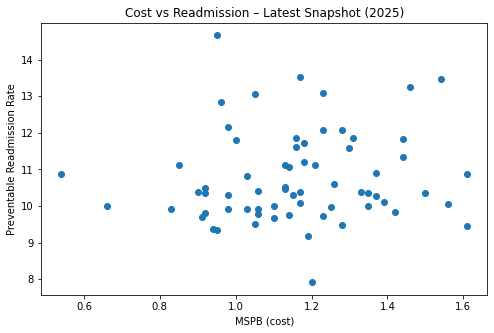

Correlation between MSPB and preventable readmissions: 0.09


In [18]:
# Identify latest snapshot year present in the file
latest_year = multi_year['snapshot_year'].max()
latest = multi_year[multi_year['snapshot_year'] == latest_year].copy()

# If there are multiple snapshots per year, keep the last one per provider
latest = latest.sort_values(['provider_id', 'snapshot_label']).groupby('provider_id').tail(1)

x = latest['Medicare Spending Per Beneficiary (MSPB)']
y = latest['Preventable Readmission Rate']

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_xlabel('MSPB (cost)')
ax.set_ylabel('Preventable Readmission Rate')
ax.set_title(f'Cost vs Readmission – Latest Snapshot ({latest_year})')
plt.show()

corr = x.corr(y)
print(f'Correlation between MSPB and preventable readmissions: {corr:.2f}')

## 3. Multi‑year trend – example measure

The `trend` table aggregates CMS measures by year. As an example, we can look at the average **Medicare Spending Per Beneficiary (MSPB)** score over time to see whether cost efficiency is improving.

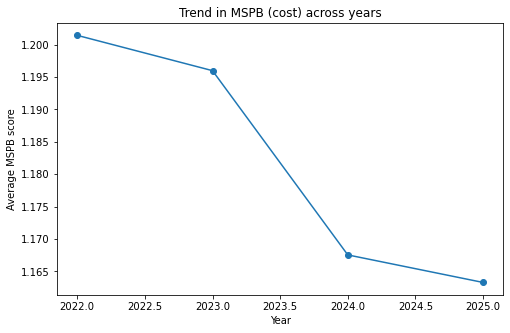

In [23]:
mspb_trend = trend[trend['measure'] == 'Medicare Spending Per Beneficiary (MSPB)'].copy()
mspb_trend['snapshot_year'] = pd.to_numeric(mspb_trend['snapshot_year'], errors='coerce')
mspb_trend['avg_score'] = pd.to_numeric(mspb_trend['avg_score'], errors='coerce')
mspb_trend = mspb_trend.sort_values('snapshot_year')

x = mspb_trend['snapshot_year'].to_numpy()        # no [:, None]
y = mspb_trend['avg_score'].to_numpy()

fig, ax = plt.subplots()
ax.plot(x, y, marker='o')
ax.set_xlabel('Year')
ax.set_ylabel('Average MSPB score')
ax.set_title('Trend in MSPB (cost) across years')
plt.show()


## 4. Top and bottom facilities by quality

Using the latest snapshot, we can rank facilities on **Preventable Readmission Rate** and highlight the best and worst performers within the service area. For context we also show MSPB cost values.

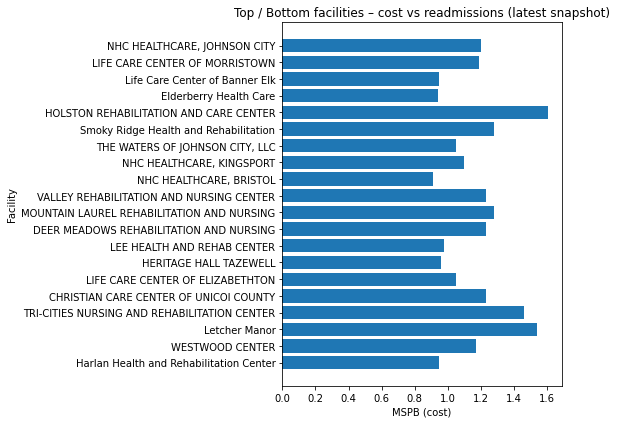

,facility_name,city,state,Preventable Readmission Rate,Medicare Spending Per Beneficiary (MSPB),rank_group
0,Harlan Health and Rehabilitation Center,Harlan,KY,14.66,0.95,Bottom 10 (worst)
1,WESTWOOD CENTER,BLUEFIELD,VA,13.53,1.17,Bottom 10 (worst)
2,Letcher Manor,Whitesburg,KY,13.47,1.54,Bottom 10 (worst)
3,TRI-CITIES NURSING AND REHABILITATION CENTER,CUMBERLAND,KY,13.24,1.46,Bottom 10 (worst)
4,CHRISTIAN CARE CENTER OF UNICOI COUNTY,ERWIN,TN,13.09,1.23,Bottom 10 (worst)
5,LIFE CARE CENTER OF ELIZABETHTON,ELIZABETHTON,TN,13.06,1.05,Bottom 10 (worst)
6,HERITAGE HALL TAZEWELL,TAZEWELL,VA,12.84,0.96,Bottom 10 (worst)
7,LEE HEALTH AND REHAB CENTER,PENNINGTON GAP,VA,12.15,0.98,Bottom 10 (worst)
8,DEER MEADOWS REHABILITATION AND NURSING,ABINGDON,VA,12.08,1.23,Bottom 10 (worst)
9,MOUNTAIN LAUREL REHABILITATION AND NURSING,RURAL RETREAT,VA,12.07,1.28,Bottom 10 (worst)


In [20]:
# Rank facilities – lower readmission is better
latest = latest.copy()
latest = latest.dropna(subset=['Preventable Readmission Rate'])

latest['readm_rank'] = latest['Preventable Readmission Rate'].rank(method='min', ascending=True)

top10 = latest.nsmallest(10, 'Preventable Readmission Rate').copy()
top10['rank_group'] = 'Top 10 (best)'

bottom10 = latest.nlargest(10, 'Preventable Readmission Rate').copy()
bottom10['rank_group'] = 'Bottom 10 (worst)'

ranked = pd.concat([bottom10, top10], ignore_index=True)

fig, ax = plt.subplots(figsize=(8, 6))
ranked_sorted = ranked.sort_values('Preventable Readmission Rate', ascending=False)
ax.barh(ranked_sorted['facility_name'], ranked_sorted['Medicare Spending Per Beneficiary (MSPB)'])
ax.set_xlabel('MSPB (cost)')
ax.set_ylabel('Facility')
ax.set_title('Top / Bottom facilities – cost vs readmissions (latest snapshot)')
plt.tight_layout()
plt.show()

ranked[['facility_name', 'city', 'state', 'Preventable Readmission Rate',
        'Medicare Spending Per Beneficiary (MSPB)', 'rank_group']].head(20)

## 5. Consistency in performance over time

One way to identify reliable partners is to look for facilities that are **consistently** high performers. For example, we can compute the standard deviation of each facility's readmission rate across years.

In [21]:
readm_history = multi_year.dropna(subset=['Preventable Readmission Rate']).copy()

consistency = (readm_history
    .groupby('provider_id')
    .agg(
        facility_name=('facility_name', 'first'),
        state=('state', 'first'),
        n_years=('snapshot_year', 'nunique'),
        avg_readm=('Preventable Readmission Rate', 'mean'),
        sd_readm=('Preventable Readmission Rate', 'std')
    )
    .query('n_years >= 3')
    .sort_values(['avg_readm', 'sd_readm'])
)

consistency.head(10)

,facility_name,state,n_years,avg_readm,sd_readm
provider_id,,,,,
445314,LIFE CARE CENTER OF MORRISTOWN,TN,4,7.926250,0.448474
345045,THE FOLEY CENTER AT CHESTNUT RIDGE,NC,4,8.059583,0.608101
495133,VALLEY REHABILITATION AND NURSING CENTER,VA,4,8.247500,0.447886
445469,IVY HALL NURSING HOME,TN,4,8.341667,0.769769
345206,MADISON HEALTH AND REHABILITATION,NC,4,8.469167,1.021580
345305,SMOKY RIDGE HEALTH AND REHABILITATION,NC,4,8.582917,0.881024
445464,HILLVIEW HEALTH CENTER,TN,4,8.625000,1.458397
445291,ERWIN HEALTH CARE CENTER,TN,4,8.713750,1.156463
445504,NEWPORT TN OPCO LLC,TN,4,8.739167,0.781637


## 6. Reference – 

1. Original files submitted by Khayn.
2. Output files generated from snf_multi_year_runner.py
3. CMS data for 2022, 2023 and 2024 needs to be downloaded manually and saved inside the folder data/archive folder.

## 7. Ideas for next steps

- Automate the quarterly CMS refresh and regeneration of the multi‑year tables.
- Link Ballad's internal claims / encounter data to track **actual 30/60/90‑day outcomes** by facility.
- Extend the composite score to include staffing ratios and case‑mix‑adjusted measures.
- Use the streamlit application and give more feedback on what to change if its share with surgical, post accute teams etc.
- Use these features as inputs to a predictive model for **post‑acute placement risk** (likelihood of readmission vs cost), to guide referral choices.